In [1]:
import numpy as np
import json
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
p1 = "/home/not81yan/km_predict_proj/Model/logs/params/24_6/best_params_5.json"
p2 = "/home/not81yan/km_predict_proj/Model/logs/params/24_6/best_params_entire.json"
p3 = "/home/not81yan/km_predict_proj/Model/logs/params/24_6/best_params_entire_2.json"
p4 = "/home/not81yan/km_predict_proj/Model/logs/params/24_6/best_params_entire_3.json"

In [3]:
# load the json files from the paths
with open(p1) as f:
    data1 = json.load(f)
with open(p2) as f:
    data2 = json.load(f)
with open(p3) as f:
    data3 = json.load(f)
with open(p4) as f:
    data4 = json.load(f)

In [4]:
#load the final_data.npz
final_data = np.load("/home/not81yan/km_predict_proj/Model/Dataset/final_data.npz")
arr = final_data['arr_0']

(92896,)


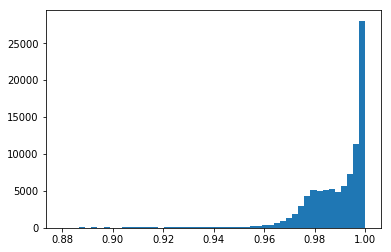

In [5]:
sim_vecs = arr[:, 0]
print(sim_vecs.shape)
#mean
mean = np.mean(sim_vecs)
#std
std = np.std(sim_vecs)
#variance
var = np.var(sim_vecs)
#median
median = np.median(sim_vecs)
#min
min_val = np.min(sim_vecs)
#max
max_val = np.max(sim_vecs)

#plot the histogram
plt.hist(sim_vecs, bins=50)
plt.show()

In [6]:
# print the statistics
print("mean: ", mean)
print("std: ", std)
print("var: ", var)
print("median: ", median)
print("min: ", min_val)
print("max: ", max_val)


mean:  0.988531611417001
std:  0.013866960267468352
var:  0.00019229258705954596
median:  0.9928586735630986
min:  0.8794161318827849
max:  1.0000000000000002


In [7]:
X = arr[:, 3:]
y = arr[:, 2]
real = arr[:, 1]#km_wildtype
#find indices where sim_vecs is greater than 0.99
# indices = np.where(sim_vecs>0.99)
# indices = indices[0]
#remove the indices from X,y,real
# X = np.delete(X, indices, axis=0)
# y = np.delete(y, indices, axis=0)
# real = np.delete(real, indices, axis=0)
sz = 0.2

X_train, X_test, y_train, y_test,r_train,r_test = train_test_split(X, y,real, test_size=(sz), random_state=42)
D_train=xgb.DMatrix(data=X_test, label=y_test)
D_test=xgb.DMatrix(data=X_train, label=y_train)


In [8]:
X_train.shape

(74316, 2560)

In [9]:
X_test.shape

(18580, 2560)

In [10]:
r_test.shape

(18580,)

In [11]:
r_train.shape

(74316,)

In [12]:
y_train.shape

(74316,)

In [13]:
y_test.shape

(18580,)

Following are the results for best_params_5_3200
Test Accuracy (km_vals): 0.55
Test Accuracy (delta): 0.49
Train Accuracy (km_vals): 0.73


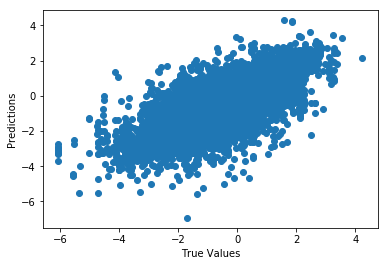

In [14]:
print(f"Following are the results for best_params_5_3200")
with open(p3) as f:
    data3 = json.load(f)
best = data3
num_round = best['num_rounds']
del best['num_rounds']
params={'max_depth': int(np.round(best['max_depth'])),
        'learning_rate': best['learning_rate'],
        'min_child_weight': best['min_child_weight'],
        'reg_alpha': best['reg_alpha'],  # L1 regularization
        'reg_lambda': best['reg_lambda'],  # L2 regularization
        'tree_method': 'gpu_hist',  # Use GPU
        'predictor': 'gpu_predictor',  # Use GPU for predictions
        'sampling_method': 'gradient_based',
        'eval_metric': 'rmse'}
best_model = xgb.train(params, xgb.DMatrix(X_train,label=y_train), int(num_round), verbose_eval=False)
predictions = best_model.predict(xgb.DMatrix(X_test, label=y_test)) 
test_accuracy = r2_score(y_test + r_test, predictions + r_test)
print("Test Accuracy (km_vals): {:.2f}".format(test_accuracy))
test_acc_deltas = r2_score(y_test, predictions)
print("Test Accuracy (delta): {:.2f}".format(test_acc_deltas))

#find the training accuracy
predictions = best_model.predict(xgb.DMatrix(X_train, label=y_train))
train_accuracy = r2_score(y_train + r_train, predictions + r_train)
print("Train Accuracy (km_vals): {:.2f}".format(train_accuracy))
# make a scatter plot
predictions = best_model.predict(xgb.DMatrix(X_test, label=y_test)) 

plt.scatter(y_test +r_test, predictions+r_test)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.show()

In [45]:
#now we will make multiple intervals of y and sim_vecs, and find the r2 score for each interval

# make the different intervals ina a grid
intervals = list(np.linspace(0, 2, 11))
intervals_ = list(np.array([0.9999,0.999,0.99,0.9]))
r2_scores = []
nums = []
for k in range(4):
    r2_scores.append([])
    nums.append([])
for i in range(1,len(intervals)):
    up = intervals[i]
    down = intervals[i-1]
    # find the indices where y is in the interval
    for j in range(0,len(intervals_)):
        threshold = intervals_[j]
        indices = np.where((y>=down) & (y<=up) & (sim_vecs>=threshold))
        indices = indices[0]
        if len(indices) == 0:
            continue
        # find the r2 score
        predictions = best_model.predict(xgb.DMatrix(X[indices,:], label=y[indices]))
#         input()
        r2 = r2_score(y[indices]+real[indices], predictions+real[indices])
#         input()
        r2_scores[j].append(r2)
        nums[j].append(len(indices))
        
        print(f"Interval: {down} to {up} and {threshold} has r2 score: {r2} \n num pts = {len(indices)}")
    


Interval: 0.0 to 0.2 and 0.9999 has r2 score: 0.9757780157573783 
 num pts = 2791
Interval: 0.0 to 0.2 and 0.999 has r2 score: 0.9703000654805578 
 num pts = 4407
Interval: 0.0 to 0.2 and 0.99 has r2 score: 0.9387885569116129 
 num pts = 7545
Interval: 0.0 to 0.2 and 0.9 has r2 score: 0.9050861972921511 
 num pts = 10797
Interval: 0.2 to 0.4 and 0.9999 has r2 score: 0.9466321154057995 
 num pts = 1311
Interval: 0.2 to 0.4 and 0.999 has r2 score: 0.9279994098449239 
 num pts = 2125
Interval: 0.2 to 0.4 and 0.99 has r2 score: 0.8882702348159569 
 num pts = 5072
Interval: 0.2 to 0.4 and 0.9 has r2 score: 0.8485159349950316 
 num pts = 8075
Interval: 0.4 to 0.6000000000000001 and 0.9999 has r2 score: 0.8921958976411407 
 num pts = 600
Interval: 0.4 to 0.6000000000000001 and 0.999 has r2 score: 0.8784139485849876 
 num pts = 1066
Interval: 0.4 to 0.6000000000000001 and 0.99 has r2 score: 0.8516154576300544 
 num pts = 3481
Interval: 0.4 to 0.6000000000000001 and 0.9 has r2 score: 0.80883327

In [46]:
# plot the r2 scores
# make a meshgrid
from mpl_toolkits.mplot3d import Axes3D  # This import registers the 3D projection, but is otherwise unused.

X1, Y1 = np.meshgrid(intervals, intervals_)
r2_scores = np.array(r2_scores)

In [47]:
X1.shape

(4, 11)

In [48]:
Y1.shape

(4, 11)

In [49]:
X1

array([[0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ],
       [0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ],
       [0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ],
       [0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]])

In [50]:
Y1

array([[0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999,
        0.9999, 0.9999, 0.9999],
       [0.999 , 0.999 , 0.999 , 0.999 , 0.999 , 0.999 , 0.999 , 0.999 ,
        0.999 , 0.999 , 0.999 ],
       [0.99  , 0.99  , 0.99  , 0.99  , 0.99  , 0.99  , 0.99  , 0.99  ,
        0.99  , 0.99  , 0.99  ],
       [0.9   , 0.9   , 0.9   , 0.9   , 0.9   , 0.9   , 0.9   , 0.9   ,
        0.9   , 0.9   , 0.9   ]])

In [51]:
r2_scores.shape

(4, 10)

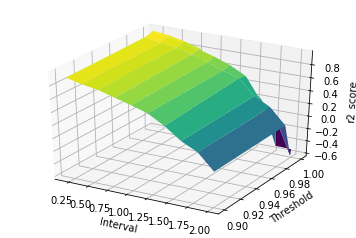

In [52]:
X1 = X1[:,1:]
Y1 = Y1[:,1:]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, Y1, r2_scores, cmap='viridis')
ax.set_xlabel('Interval')
ax.set_ylabel('Threshold')
ax.set_zlabel('r2_score')
plt.show()

#use plotly for an interacting surface plot and save to html file
import plotly.graph_objects as go
fig = go.Figure(data=[go.Surface(z=r2_scores, x=intervals, y=intervals_)])
fig.update_layout(title='r2 scores for different intervals and thresholds',
                  scene = dict(
                    xaxis_title='Interval',
                    yaxis_title='Threshold',
                    zaxis_title='r2_score'))
# py.plot(fig, filename='r2_scores_all.html') 
fig.show()

In [53]:
fig.write_html("./r2_scores.html")

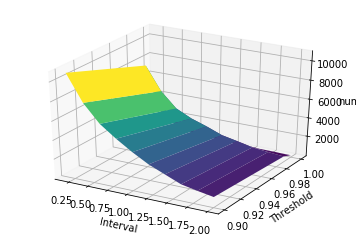

In [54]:
nums = np.array(nums)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, Y1, nums, cmap='viridis')
ax.set_xlabel('Interval')
ax.set_ylabel('Threshold')
ax.set_zlabel('nums')
plt.show()

#use plotly for an interacting surface plot and save to html file
import plotly.graph_objects as go
fig = go.Figure(data=[go.Surface(z=nums, x=intervals, y=intervals_)])
fig.update_layout(title='r2 scores for different intervals and thresholds',
                  scene = dict(
                    xaxis_title='Interval',
                    yaxis_title='Threshold',
                    zaxis_title='nums'))
# py.plot(fig, filename='nums_all.html') 
fig.show()

In [55]:
fig.write_html("./nums.html")

In [56]:
nums.shape

(4, 10)

In [57]:
sm = np.sum(nums, axis=0)

In [58]:
sm

array([25540, 16583, 11388,  8883,  6935,  5077,  3847,  2637,  2069,
        1557])

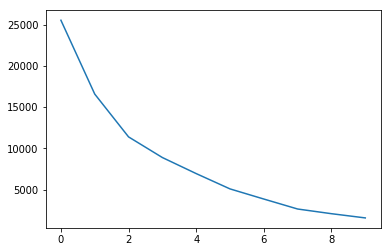

In [59]:
plt.plot(sm)
plt.show()

In [65]:
new_s = []
for i in range(0,len(sm),2):
    try:
        new_s.append(sm[i]+sm[i+1])
    except:
        new_s.append(sm[i])
        
print(len(new_s))

5


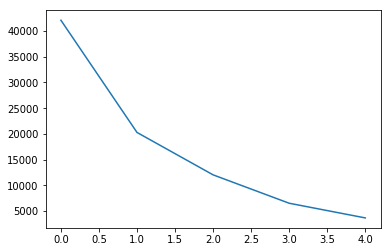

In [63]:
plt.plot(new_s)
plt.show()